In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# from sklearn.metrics import accuracy_score
# from sklearn.metrics import confusion_matrix

In [33]:
df = pd.read_csv("../data/raw/fairlabs_data.csv", 
                parse_dates=["uds_collection_date", "cps_reporting_date"])

In [10]:
KEY_COLUMN_NAME = 'encounter_id'
ACTION_COLUMN_NAME = 'uds_order_id'
RESULTS_COLUMN_NAME = 'cps_reporting_date'

SENSITIVE_COLUMN_NAME = 'maternal_race'

COLOR = "#009999"

#### Outlier Handling

In [11]:
def detect_outliers_iqr(data, column, multiplier=1.5):
    """
    Detect outliers using the Interquartile Range (IQR) method.

    Parameters:
        data (array-like): Data to detect outliers from.
        multiplier (float): Multiplier for the IQR. Defaults to 1.5.

    Returns:
        outliers (list): List of outlier values.
    """
    # Calculate the first and third quartiles
    Q1 = np.percentile(data[column], 25)
    Q3 = np.percentile(data[column], 75)

    # Calculate the interquartile range (IQR)
    IQR = Q3 - Q1

    # Define the outlier bounds
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR

    # Identify outliers
    outliers = [value for value in data[column] if value < lower_bound or value > upper_bound]
    outliers_encounter_id = data.loc[(data[column] < lower_bound) | (data[column] > upper_bound), 'encounter_id'].tolist()

    return outliers, outliers_encounter_id

In [12]:
def remove_rows_by_column_value(data, column_name, column_values):
    """
    Remove rows with specified column values from the DataFrame.

    Parameters:
        data (DataFrame): DataFrame containing the data.
        column_name (str): Name of the column to check for values.
        column_values (list): List of values to remove.

    Returns:
        cleaned_data (DataFrame): DataFrame with specified rows removed.
    """
    cleaned_data = data[~data[column_name].isin(column_values)].copy()
    print("Dataframe shape before removing rows:", data.shape)
    print("Dataframe shape after removing rows:", cleaned_data.shape)

    return cleaned_data

In [18]:
def find_and_remove_outliers(data=df, column_name=column_name, multiplier=multiplier):
    outliers, outliers_encounter_id = detect_outliers_iqr(data=df, column='maternal_age', multiplier=multiplier)
    print(f"Outliers detected in the column {column_name} using IQR method with multiplier {multiplier}:")
    for i, outlier in enumerate(outliers):
        print(f"Outlier: {outlier}, Encounter ID: {outliers_encounter_id[i]}")
    
    return remove_rows_by_column_value(data=df, column_name=KEY_COLUMN_NAME, column_values=outliers_encounter_id)

In [19]:
multiplier=2.5
column_name="maternal_age"
new_df = find_and_remove_outliers(data=df, column_name=column_name, multiplier=multiplier)

Outliers detected in the column maternal_age using IQR method with multiplier 2.5:
Outlier: 123, Encounter ID: encounter_6813
Dataframe shape before removing rows: (6643, 55)
Dataframe shape after removing rows: (6642, 55)


### Data Cleaning

In [272]:
def filter_dataframe(df, column):
    """
    Filter DataFrame to remove rows containing '\r' or '\n' in the specified column.
    
    Args:
    - df: DataFrame to filter
    - column: Column to check for '\r' or '\n'
    
    Returns:
    - Filtered DataFrame
    """
    return df[~df[column].str.contains(r'\r|\n')]
    
    
def value_counts_with_percentage(df, column):
    """
    Calculate value counts and percentage for each unique value in the specified column.
    
    Args:
    - df: DataFrame to calculate value counts and percentages
    - column: Column for which value counts and percentages are calculated
    
    Returns:
    - DataFrame with value counts and percentage for each unique value in the column
    """
    value_counts = df[column].value_counts()
    total_count = len(df)
    percentage = (value_counts / total_count) * 100
    
    result_df = pd.DataFrame({'count': value_counts, 'percentage': percentage})
    return result_df


def filter_with_percentage(data, column, percent_thresh):
    freq_df = value_counts_with_percentage(df, "maternal_race")
    filtered_df = df[df[column].isin(freq_df[freq_df['percentage'] > percent_thresh].index)]
    return filtered_df

In [294]:
df_x = filter_dataframe(df, "maternal_race")
# df_y = value_counts_with_percentage(df, "maternal_race")
df_z = filter_with_percentage(data=df_x, column="maternal_race", percent_thresh=5)

In [297]:
df_y = value_counts_with_percentage(df, "maternal_race")
df_y

,count,percentage
White,3104,48.138958
Black or African American,2933,45.486973
Asian,301,4.668114
Other Pacific Islander,60,0.930521
Unable to Answer,50,0.775434


In [295]:
df.shape, df_z.shape

((6448, 57), (6037, 57))

In [75]:
# def filter_top_n_races(data, column_name, n=5):
#     """
#     Filter the data to include only the top n most common values in the specified column.

#     Parameters:
#         data (DataFrame): DataFrame containing the data.
#         column_name (str): Name of the column to filter.
#         n (int): Number of most common values to include. Defaults to 5.

#     Returns:
#         filtered_data (DataFrame): DataFrame with data filtered based on the top n most common values.
#     """
#     top_n_values = data[column_name].value_counts()[:n].index.tolist()
#     filtered_data = data[data[column_name].isin(top_n_values)].copy()
#     return filtered_data

prepare data

In [298]:
def split_data_by_date(data, split_date='2028-03-01'):
    before_df = data[data['uds_collection_date'] < split_date]
    after_df = data[data['uds_collection_date'] >= split_date]
    return before_df, after_df

In [177]:
filtered_df = filter_top_n_races(data=df, column_name='maternal_race', n=5)
print(f"Data filtered for top 5 races. previous dims: {filtered_df.shape}, current dims: {df.shape}")
df = filtered_df
df['cps_reported'] = df['cps_reporting_date'].notna().astype(int)
drug_tst_cols = [col for col in df.columns if "detected" in col]
df['uds_positive'] = df[drug_tst_cols].any(axis=1).astype(int)
before_df, after_df = split_data_by_date(data=df, split_date='2028-03-01')
before_df.to_csv("../data/interim/top5-races_df_before.csv")
after_df.to_csv("../data/interim/top5-races_df_after.csv")

Data filtered for top 5 races. previous dims: (6448, 57), current dims: (6448, 57)


### Fairness Concepts

- [X] Demographic parity
- [X] Equalized odds
- [ ] Predictive parity
- [ ] Equal Outcomes

In [178]:
def check_demographic_parity(df):
    df = df.copy()

    proportion_per_race = dict(df.groupby('maternal_race')['cps_reported'].mean())
    overall_proportion = df['cps_reported'].mean()

    return proportion_per_race, overall_proportion


def create_barh_chart(categories, values, xlabel='', ylabel='', title='', color=COLOR, figsize=(10, 6), ax=None):
    # plt.figure(figsize=figsize)
    # plt.barh(categories, values, color=color)
    # plt.xlabel(xlabel)
    # plt.ylabel(ylabel)
    # plt.title(title)
    # plt.show()

    if ax is None:
        fig, ax = plt.subplots()
    
    ax.barh(categories, values, color=color)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)


def plot_demographic_parity(df):
    racial_groups = list(check_demographic_parity(df=before_df)[0].keys())
    proportions = list(check_demographic_parity(df=before_df)[0].values())  
    create_barh_chart(categories=racial_groups, values=proportions, title="Proportion of CPS reporting by Racial Group", xlabel="Proportion of CPS reporting")


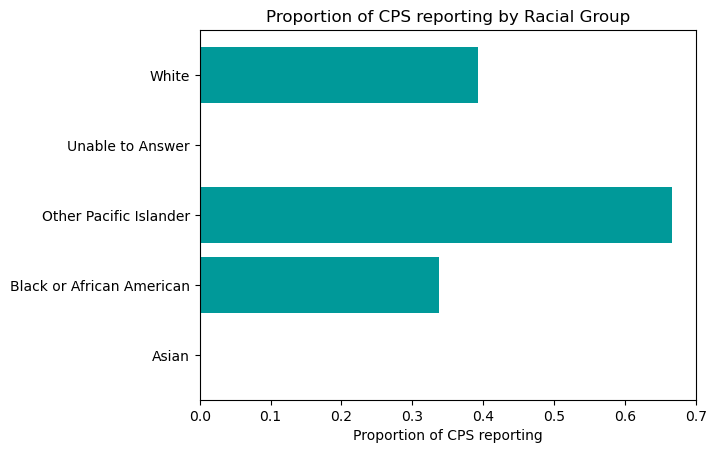

In [179]:
plot_demographic_parity(before_df)

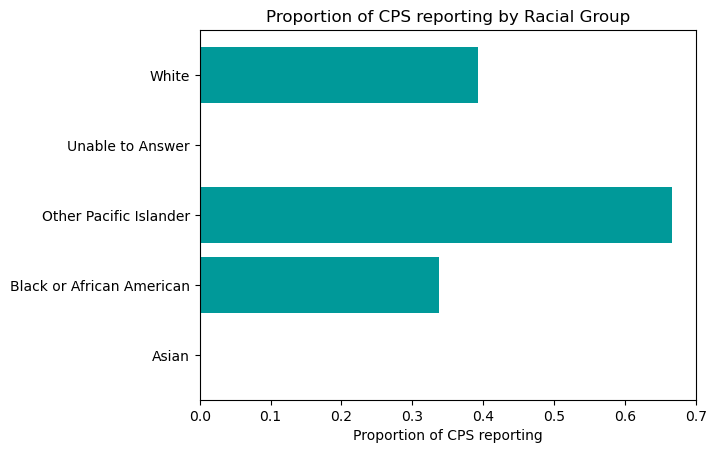

In [180]:
plot_demographic_parity(after_df)

In [187]:
tn, fp, fn, tp = confusion_matrix(df["uds_positive"], df["cps_reported"]).ravel()

equalised odds

In [260]:
def calculate_fairness_metrics(df, sensitive_column, truth_col='uds_positive', predicted_col='cps_reported'):
    # Initialize an empty dictionary to store the results
    result_dict = {'group': [], 'tp': [], 'tn': [], 'fp': [], 'fn': [], 'proportion_positive': [], 'tpr': [], 'tnr': [], 'fpr': [], 'ppp': []}
    
    # Group the DataFrame by the sensitive column
    grouped = df.groupby(sensitive_column)
    
    # Calculate metrics for each group
    for group, data in grouped:
        tp = sum((data[truth_col] == 1) & (data[predicted_col] == 1))
        tn = sum((data[truth_col] == 0) & (data[predicted_col] == 0))
        fp = sum((data[truth_col] == 0) & (data[predicted_col] == 1))
        fn = sum((data[truth_col] == 1) & (data[predicted_col] == 0))
        
        total = len(data)
        proportion_positive = data[predicted_col].mean()
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        tnr = tn / (tn + fp) if (tn + fp) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        ### predicted as positive
        ppp = (tp+fp)/(tp+fp+tn+fn)
        
        # Append metrics to the result dictionary
        result_dict['group'].append(group)
        result_dict['tp'].append(tp)
        result_dict['tn'].append(tn)
        result_dict['fp'].append(fp)
        result_dict['fn'].append(fn)
        result_dict['proportion_positive'].append(proportion_positive)
        result_dict['tpr'].append(tpr)
        result_dict['tnr'].append(tnr)
        result_dict['fpr'].append(fpr)
        result_dict['ppp'].append(ppp)
    
    # Convert the dictionary to a DataFrame
    result_df = pd.DataFrame(result_dict)
    
    return result_df

result_df_before = calculate_fairness_metrics(df=before_df, sensitive_column='maternal_race')
result_df_after = calculate_fairness_metrics(df=after_df, sensitive_column='maternal_race')

In [261]:
result_df_after

,group,tp,tn,fp,fn,proportion_positive,tpr,tnr,fpr,ppp
0,Black or African American,44,32,0,18,0.468085,0.709677,1.000000,0.000000,0.468085
1,Other Pacific Islander,0,0,0,1,0.000000,0.000000,0.000000,0.000000,0.000000
2,White,37,11,1,17,0.575758,0.685185,0.916667,0.083333,0.575758


In [262]:
result_df_before

,group,tp,tn,fp,fn,proportion_positive,tpr,tnr,fpr,ppp
0,Asian,0,4,0,0,0.000000,0.000000,1.000000,0.000000,0.000000
1,Black or African American,118,138,3,100,0.337047,0.541284,0.978723,0.021277,0.337047
2,Other Pacific Islander,1,1,1,0,0.666667,1.000000,0.500000,0.500000,0.666667
3,Unable to Answer,0,1,0,0,0.000000,0.000000,1.000000,0.000000,0.000000
4,White,63,61,1,38,0.392638,0.623762,0.983871,0.016129,0.392638


In [263]:
result_df_before.columns

Index(['group', 'tp', 'tn', 'fp', 'fn', 'proportion_positive', 'tpr', 'tnr',
       'fpr', 'ppp'],
      dtype='object')

In [264]:
# similar_proportion_positive = 
result_df_before['proportion_positive'].std() < 0.05

False

In [268]:
def visualize_fairness(df):
    plt.figure(figsize=(10, 6))
    
    # Bar plot for proportion positive
    plt.subplot(2, 2, 1)
    sns.barplot(x='group', y='proportion_positive', data=df)
    plt.title('Proportion Positive by Group')
    
    # Bar plot for true positive rate
    plt.subplot(2, 2, 2)
    sns.barplot(x='group', y='tpr', data=df)
    plt.title('True Positive Rate (TPR) by Group')
    
    # Bar plot for true negative rate
    plt.subplot(2, 2, 3)
    sns.barplot(x='group', y='tnr', data=df)
    plt.title('True Negative Rate (TNR) by Group')
    
    plt.tight_layout()
    plt.show()

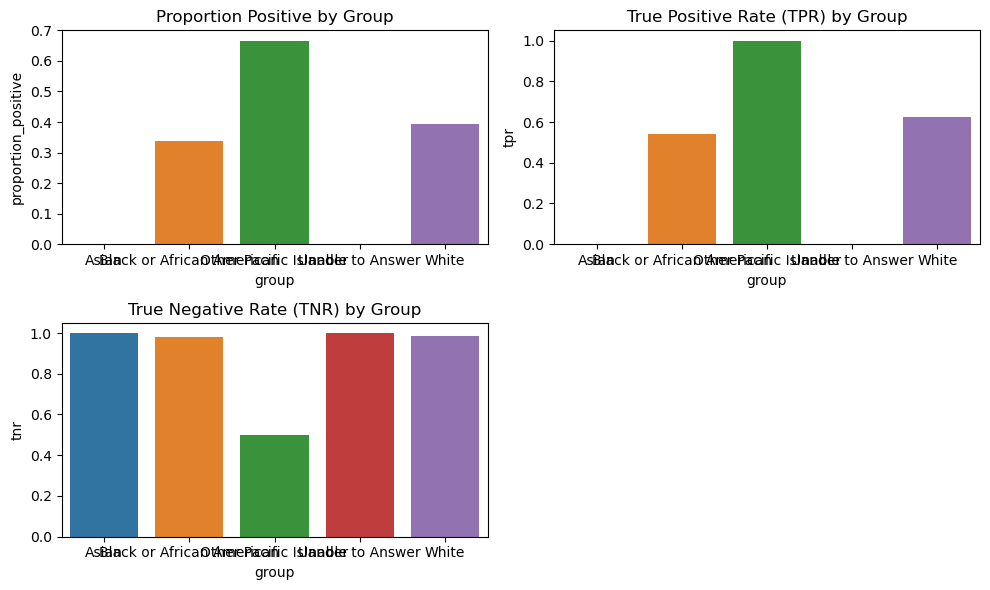

In [270]:
visualize_fairness(df=result_df_before)